In [1]:
import sys
import numpy as np
from torch.nn.functional import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List


sys.path.append('../')
from vis_utils import plot_pr_eval

In [3]:
def plot_auroc_eval(
    data_key: str = 'brain',
    # data_key: str = 'heart',

    architectures: List[str] = [
        'ResDAE-8',
        'ResDAE-32',
        'ResDAE-64',
    ],
    unets: List[str] = [
        'default-8', 
        # 'default-16', 
        # 'monai-8-4-4',
        'monai-16-4-4',
        # 'monai-16-4-8',
        # 'monai-32-4-4',
        # 'monai-64-4-4',
        # 'swinunetr'
    ],
    debug: bool = False,
):
    dfs = []
    load_dir = '../../results-tmp/dae-data/'
    for arch in architectures:
        for unet in unets:
            file_name = f'auroc_{data_key}_{arch}_{unet}_0.csv'
            if debug:
                file_name = 'debug_' + file_name
            df_tmp = pd.read_csv(
                load_dir + file_name
            )
            # df_tmp['method'] = arch
            dfs.append(df_tmp)
    df = pd.concat(dfs)

    df['method'] = df['method'].apply(lambda x: x.split('-')[0])
    df['method'] = df['method'].apply(lambda x: x.split('_')[0])

    # for row in df['auroc']:
    #     if isinstance(row, str):
    #         print(row)
    # if len(unets) == 1:
    #     df['method_with_auroc'] = df.apply(lambda row: f"{row['method']} ({row['auroc']})", axis=1)

    df['domain'] = df['domain'].apply(str)
    df['domain'] = df['domain'].str.replace("_subset", "", regex=True)
    df = df[df['domain'] != 'train']
    df = df[df['domain'] != 'train_subset']
    df = df[df['domain'] != 'val']
    df = df[df['domain'] != 'val_subset']
    # df['domain'].replace("Domain", "", inplace=True, regex=False)
    #, regex=False

    n = df['domain'].nunique()
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))

    for i, domain in enumerate(df['domain'].unique()):
        sns.lineplot(
            data=df[df['domain'] == domain], 
            x='fpr',
            y='tpr', 
            hue='method',
            style='unet',
            ax=axes[i]
        )
        axes[i].set_title(f'Domain {domain}')
        axes[i].set_ylim(0, 1)

    fig.suptitle(f'{data_key.capitalize()} Data - AUROC', fontsize=16)
    # plt.close(fig)

    return fig

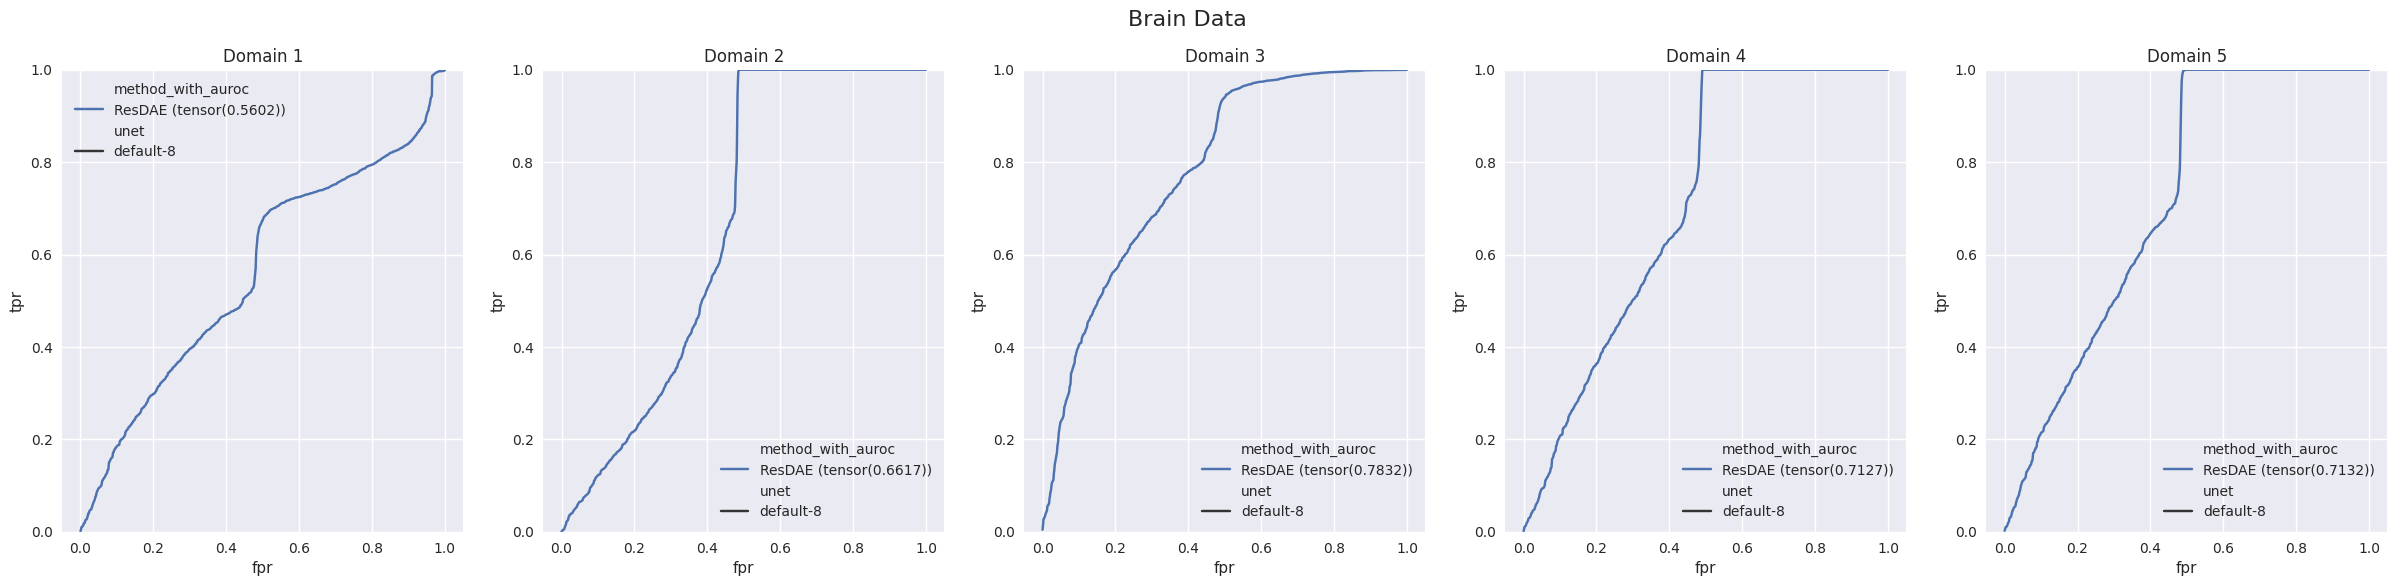

In [74]:
auroc_brain = plot_auroc_eval(
    data_key='brain',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        # 'ResDAE-all-32-instance-reconstruction',
        'ResDAE-bottleneck-32_instance-reconstruction',
        # 'CompressionDAE-bottleneck-3-4_residual',
        # 'mahalanobis'
        # 'ResDAE-all-32-instance-reconstruction'
    ],
    unets=[
        'default-8',
        # 'monai-16-4-4',
    ],
    debug=False
)
# auroc_heart = plot_auroc_eval(
#     data_key='heart',
#     architectures=[
#         # 'ResDAE-bottleneck-32_instance-reconstruction_full',
#         # 'ResDAE-all-32-instance-reconstruction',
#         'ResDAE-bottleneck-32_instance-reconstruction',
#         'CompressionDAE-bottleneck-3-4_residual',
#         'mahalanobis'
#         # 'ResDAE-all-32-instance-reconstruction'
#     ],
#     unets=[
#         'default-8',
#         # 'monai-16-4-4',
#     ],
#     debug=False
# )

In [4]:
def plot_eaurc_eval(
    data_key: str = 'brain',
    # data_key: str = 'heart',

    architectures: List[str] = [
        'ResDAE-8',
        'ResDAE-32',
        'ResDAE-64',
    ],
    unets: List[str] = [
        'default-8', 
        # 'default-16', 
        # 'monai-8-4-4',
        'monai-16-4-4',
        # 'monai-16-4-8',
        # 'monai-32-4-4',
        # 'monai-64-4-4',
        # 'swinunetr'
    ],
    debug: bool = False,
):  
    plt.style.use("seaborn-v0_8")
    dfs = []
    load_dir = '../../results-tmp/dae-data/'
    for arch in architectures:
        for unet in unets:
            file_name = f'eaurc_{data_key}_{arch}_{unet}_0.csv'
            if debug:
                file_name = 'debug_' + file_name
            df_tmp = pd.read_csv(
                load_dir + file_name
            )
            # df_tmp['method'] = arch
            dfs.append(df_tmp)
    df = pd.concat(dfs)

    # print(str(df['domain']).head())
    df['domain'] = df['domain'].apply(str)
    df['domain'] = df['domain'].str.replace("_subset", "", regex=True)
    df = df[df['domain'] != 'train']
    df = df[df['domain'] != 'train_subset']
    # df['domain'].replace("Domain", "", inplace=True, regex=False)
    #, regex=False

    n = df['domain'].nunique()
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6), sharey=True)
    
    df_selective = df.copy()
    df_selective = df_selective[df_selective['method'] == architectures[0]]
    df_selective['method'] = 'Post-hoc'
    df_selective['risks'] = df_selective['selective_risks']

    df = pd.concat([df, df_selective])

    # df['method'] = df['method'].apply(lambda x: x.split('-')[0])
    # df['method'] = df['method'].apply(lambda x: x.split('_')[0])
    df['method'].replace('entropy',  'unet-entropy', inplace=True, regex=False) 
    df['method'].replace('top2diff', 'unet-top2diff', inplace=True, regex=False) 
    # df['method'] = df['method'].apply(lambda x: f"{x.split('-')[0]} {x.split('-')[-1]}")
    # df['method'] = df['method'].apply(lambda x: x.split('_')[0])
    if len(unets) == 1:
        df['method_with_eaurc'] = df.apply(lambda row: f"{row['method']} ({row['eaurc']:.6f})", axis=1)

    for i, domain in enumerate(df['domain'].unique()):
        sns.lineplot(
            data=df[df['domain'] == domain], 
            x='weights',
            y='risks', 
            hue='method_with_eaurc',
            style='unet',
            ax=axes[i]
        )
        axes[i].set_title(f'Domain {domain}')
        # axes[i].set_yscale('log')
        # sns.lineplot(
        #     data=df_selective[df_selective['domain'] == domain], 
        #     x='weights',
        #     y='selective_risks', 
        #     hue='method',
        #     style='unet',
        #     ax=axes[i]
        # )
        axes[i].set_xlim(0, 1)
        if data_key == 'brain':
            axes[i].set_ylim(0, 0.0109)
        else:
            axes[i].set_ylim(0, 0.015)

        axes[i].set_xlabel('Confidence')
        axes[i].set_ylabel('Risk')
        # if i != 0:
        #     axes[i].get_legend().remove()

    fig.suptitle(f'{data_key.capitalize()} Data - EAURC', fontsize=16)
    # plt.close(fig)

    return fig

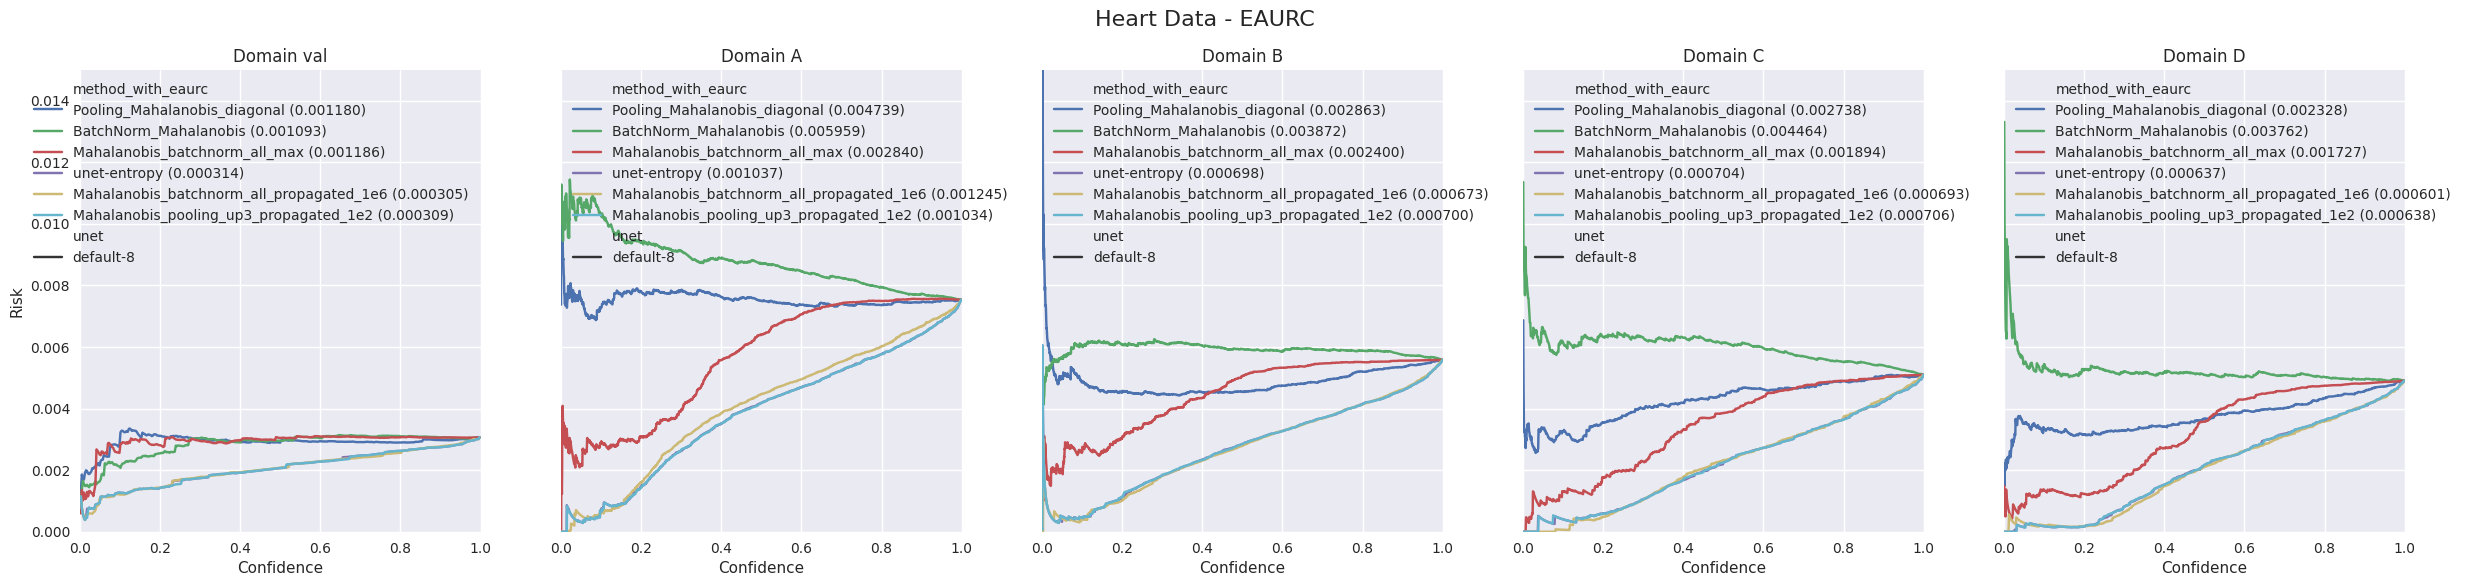

In [15]:
# auroc_heart = plot_auroc_eval(
#     data_key='heart',
#     architectures=[
#         # 'ResDAE-bottleneck-32_instance-reconstruction_full',
#         # 'ResDAE-all-32-instance-reconstruction',
#         'ResDAE-bottleneck-32_denoise-only',
#         # 'CompressionDAE-bottleneck-3-4_residual',
#         # 'ResMAE-bottleneck-128_masked7-128',
#         # 'ResMAE-bottleneck-128_masked7true-128',
#         # 'ResDAE-bottleneck-32_denoise-only',
#         # 'ResDAE-bottleneck-128_denoise-only',
#         'ChannelDAE-bottleneck-3-4-crossentropy',
#         'CompressionDAE-bottleneck-3-4_reconstruction',
#         'mahalanobis',
#         'ResMAE-bottleneck-128_masked_perpixel_0-6',
#         'entropy'
#         # 'ResDAE-all-32-instance-reconstruction'
#     ],
#     unets=[
#         'default-8',
#         # 'monai-16-4-4',
#     ],
#     debug=False
# )
# auroc_heart.savefig(f'../../results/auroc_heart_21-3-24.jpg', bbox_inches='tight')


eaurc_heart = plot_eaurc_eval(
    data_key='heart',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        # 'ResDAE-all-32-instance-reconstruction',
        # 'ResDAE-bottleneck-32_denoise-only',
        # 'CompressionDAE-bottleneck-3-4_residual',
        # 'ResMAE-bottleneck-128_masked7-128',
        # 'ResMAE-bottleneck-128_masked7true-128',
        # 'ResDAE-bottleneck-32_denoise-only',
        # 'ResDAE-bottleneck-128_denoise-only',
        # 'mahalanobis',
        # 'mahalanobis_default',
        'mahalanobis_diagonal_large',
        # 'mahalanobis_batchnorm_all',
        'mahalanobis_batchnorm_all_max',
        # 'mahalanobis_diagonal_large',
        # 'mahalanobis_diagonal',
        
        # 'CompressionDAE-bottleneck-3-4_reconstruction',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-6',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-9',
        # 'ChannelDAE-bottleneck-3-4-crossentropy',
        'entropy',
        'mahalanobis_batchnorm_all_propagated_1e6',
        'mahalanobis_pooling_up3_propagated_1e2',
        # 'mahalanobis_batchnorm_all_propagated_8e6'
        # 'top2diff'
        # 'ResDAE-all-32-instance-reconstruction'
    ],
    unets=[
        'default-8',
        # 'monai-16-4-4',
    ],
    debug=False
)
# eaurc_heart.savefig(f'../../results/eaurc_heart_27-3-24.jpg', bbox_inches='tight')

/tmp/ipykernel_2956866/3874202503.py:30: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmp = pd.read_csv(


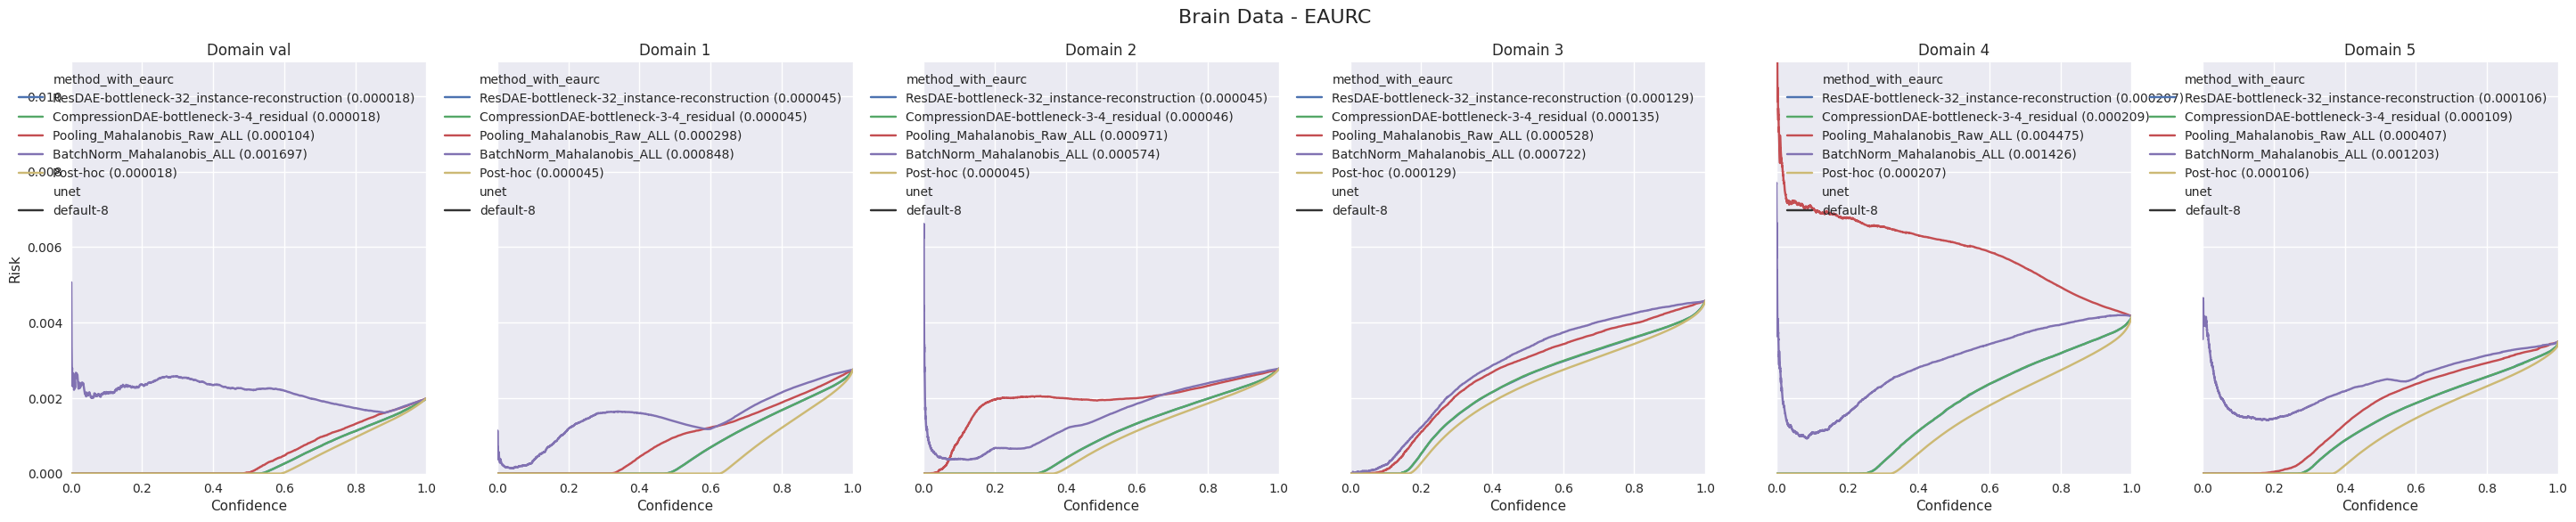

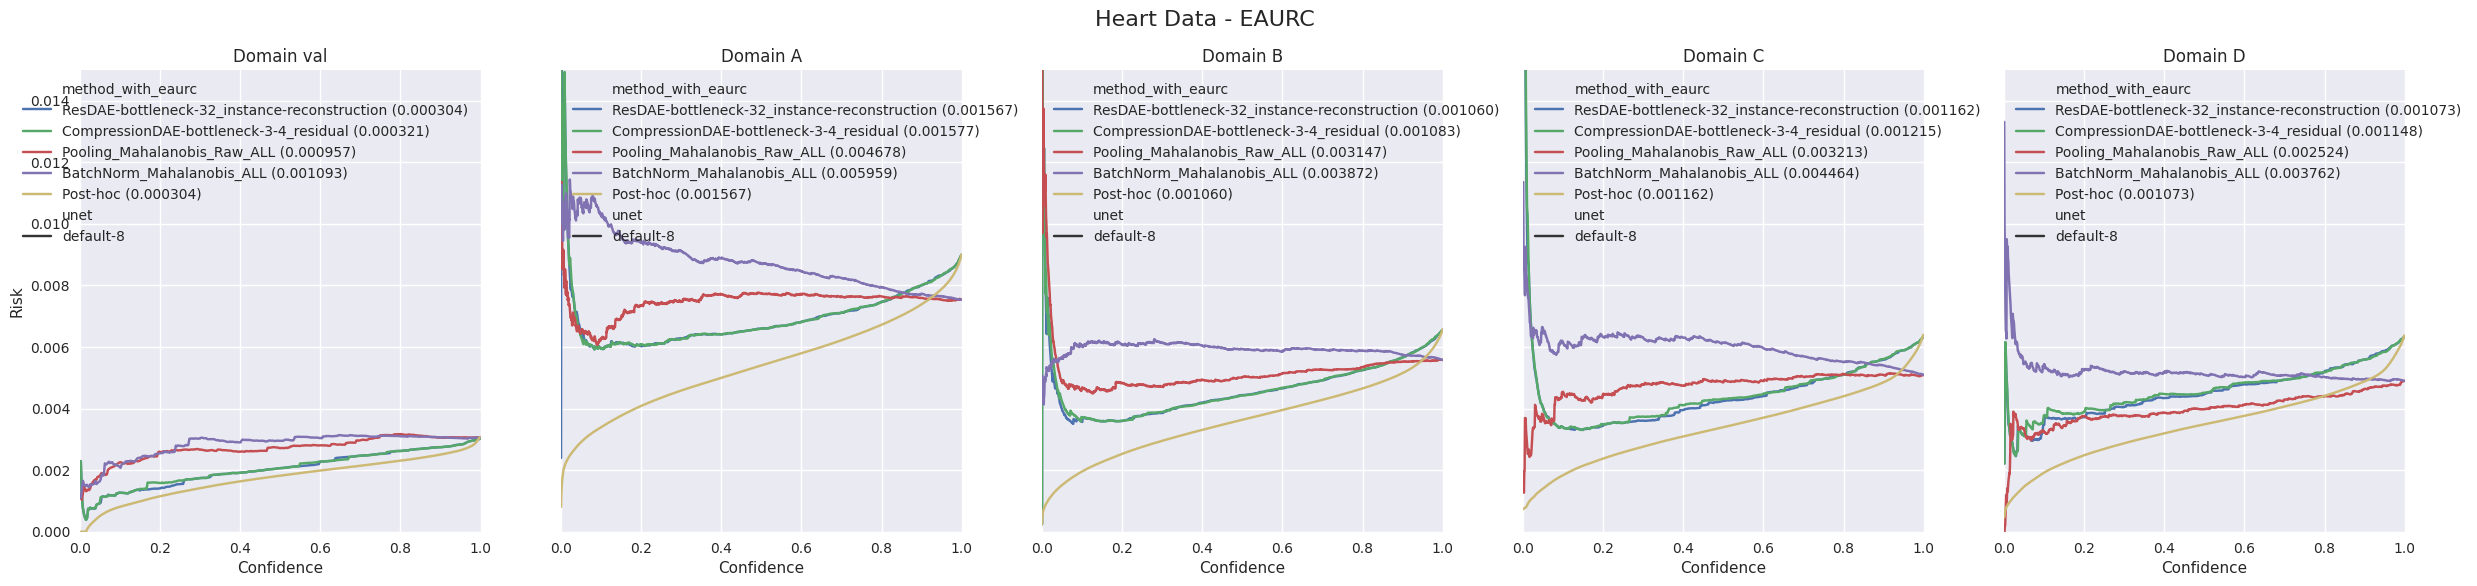

In [7]:
eaurc_brain = plot_eaurc_eval(
    data_key='brain',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        # 'ResDAE-all-32-instance-reconstruction',
        'ResDAE-bottleneck-32_instance-reconstruction',
        'CompressionDAE-bottleneck-3-4_residual',
        'mahalanobis'
        # 'ResDAE-all-32-instance-reconstruction'
    ],
    unets=[
        'default-8',
        # 'monai-16-4-4',
    ],
    debug=False
)

eaurc_heart = plot_eaurc_eval(
    data_key='heart',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        # 'ResDAE-all-32-instance-reconstruction',
        'ResDAE-bottleneck-32_instance-reconstruction',
        'CompressionDAE-bottleneck-3-4_residual',
        'mahalanobis'
        # 'ResDAE-all-32-instance-reconstruction'
    ],
    unets=[
        'default-8',
        # 'monai-16-4-4',
    ],
    debug=False
)

In [29]:
# auroc_heart = plot_auroc_eval(
#     data_key='heart',
#     architectures=[
#         # 'ResDAE-bottleneck-32_instance-reconstruction_full',
#         # 'ResDAE-all-32-instance-reconstruction',
#         'ResDAE-bottleneck-32_denoise-only',
#         # 'CompressionDAE-bottleneck-3-4_residual',
#         'ResMAE-bottleneck-128_masked7-128',
#         # 'ResMAE-bottleneck-128_masked7true-128',
#         # 'ResDAE-bottleneck-32_denoise-only',
#         # 'ResDAE-bottleneck-128_denoise-only',
#         'ChannelDAE-bottleneck-3-4',
#         'CompressionDAE-bottleneck-3-4_reconstruction',
#         'mahalanobis',
#         'entropy'
#         # 'ResDAE-all-32-instance-reconstruction'
#     ],
#     unets=[
#         'default-8',
#         # 'monai-16-4-4',
#     ],
#     debug=False
# )


eaurc_heart = plot_eaurc_eval(
    data_key='heart',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        # 'ResDAE-all-32-instance-reconstruction',
        'ResDAE-bottleneck-32_denoise-only',
        # 'CompressionDAE-bottleneck-3-4_residual',
        'ResMAE-bottleneck-128_masked7-128',
        # 'ResMAE-bottleneck-128_masked7true-128',
        # 'ResDAE-bottleneck-32_denoise-only',
        # 'ResDAE-bottleneck-128_denoise-only',
        'ChannelDAE-bottleneck-3-4',
        'CompressionDAE-bottleneck-3-4_reconstruction',
        'mahalanobis',
        'entropy'
        # 'ResDAE-all-32-instance-reconstruction'
    ],
    unets=[
        'default-8',
        # 'monai-16-4-4',
    ],
    debug=False
)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [2]:

def plot_pr_eval(
    data_key: str = 'brain',
    # data_key: str = 'heart',

    architectures: List[str] = [
        'ResDAE-8',
        'ResDAE-32',
        'ResDAE-64',
    ],
    unets: List[str] = [
        # 'default-8', 
        # 'default-16', 
        'monai-8-4-4',
        # 'monai-16-4-4',
        # 'monai-16-4-8',
        # 'monai-32-4-4',
        # 'monai-64-4-4',
        # 'swinunetr'
    ],
    debug: bool = False,
):
    dfs = []
    load_dir = '../../results-tmp/dae-data/'
    for arch in architectures:
        for unet in unets:
            file_name = f'{data_key}_{arch}_{unet}_0.csv'
            if debug:
                file_name = 'debug_' + file_name
            df_tmp = pd.read_csv(
                load_dir + file_name
            )
            df_tmp['method'] = arch
            dfs.append(df_tmp)
    df = pd.concat(dfs)
    # df['method'].replace('pr_entropy',  'unet-entropy', inplace=True, regex=False) 
    # df['method'].replace('pr_top2diff', 'unet-top2diff', inplace=True, regex=False) 

    # df['method'] = df['method'].apply(lambda x: f"{x.split('-')[0]} {x.split('-')[-1]}")
    # df['method'] = df['method'].apply(lambda x: x.split('_')[0])
    if len(unets) == 1:
        df['method_with_auc'] = df.apply(lambda row: f"{row['method']} ({row['pr_auc']:.3f})", axis=1)
    # print(str(df['domain']).head())
    df['domain'] = df['domain'].apply(str)
    df['domain'] = df['domain'].str.replace("_subset", "", regex=True)


    # df['domain'].replace("Domain", "", inplace=True, regex=False)
    #, regex=False
    # df['method'] = df['method'].apply(lambda x: c)

    # Creating the figure and axes for the subplots
    if data_key == 'heart':
        df = df[df['domain'] != 'val']
        df = df[df['domain'] != 'train']
    n = df['domain'].nunique()
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))

    for i, domain in enumerate(df['domain'].unique()):
        # if domain == 'val' and data_key == 'heart':
        #     continue
        
        sns.lineplot(
            data=df[df['domain'] == domain], 
            x='recall',
            y='precision', 
            hue='method_with_auc' if len(unets) == 1 else 'method',
            style='unet',
            ax=axes[i]
        )
        axes[i].set_title(f'Domain {domain}')
        axes[i].set_ylim(0, 1)
        # if i != 0:
        #     axes[i].get_legend().remove()

    fig.suptitle(f'{data_key.capitalize()} Data - Precision/Recall', fontsize=16)
    # plt.close(fig)

    return fig

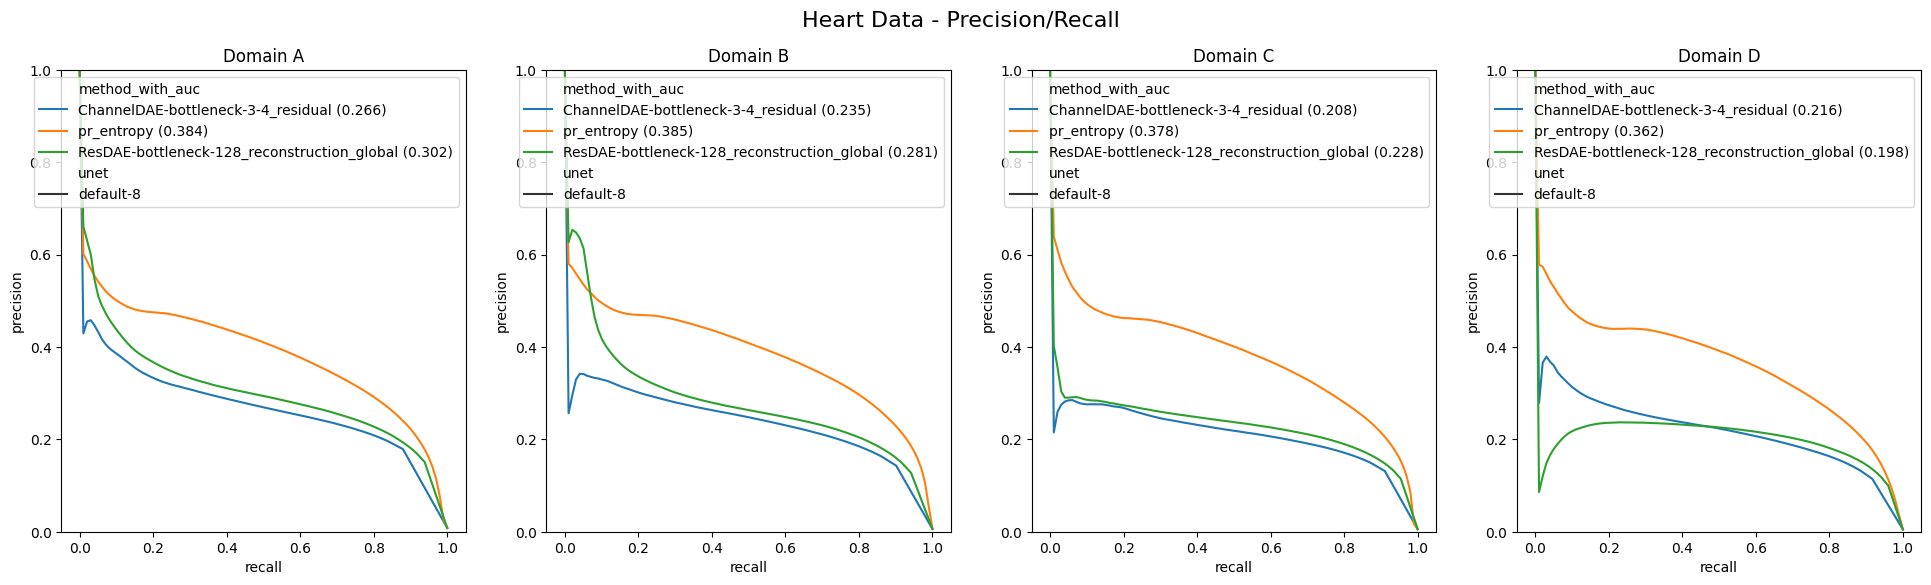

In [6]:
# pr_brain = plot_pr_eval(
#     data_key='brain',
#     architectures=[
#         # 'ResDAE-bottleneck-32_instance-reconstruction_full',
#         # 'ResDAE-all-32-instance-reconstruction',
#         'ResDAE-bottleneck-32_instance-reconstruction',
#         'ResDAE-bottleneck-32_denoise-only',
#         # 'CompressionDAE-bottleneck-3-4_residual',
#         # 'pr_entropy'
#         # 'ResDAE-all-32-instance-reconstruction'
#     ],
#     unets=[
#         'default-8',
#         # 'monai-16-4-4',
#     ],
#     debug=False
# )

pr_heart = plot_pr_eval(
    data_key='heart',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        # 'ResDAE-bottleneck-32_denoise-only',
        # 'ResMAE-bottleneck-32_masked',
        # 'ResMAE-bottleneck-32_masked7',
        # 'ResMAE-bottleneck-128_masked7-128',
        # 'ResMAE-bottleneck-128_masked7true-128',
        # 'ResDAE-bottleneck-32_denoise-only',
        # 'ResDAE-bottleneck-128_denoise-only',
        # 'CompressionDAE-bottleneck-3-4_reconstruction',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-6',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-8',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-9',
        'ChannelDAE-bottleneck-3-4_residual',
        'pr_entropy',
        'ResDAE-bottleneck-128_reconstruction_global'
        # 'pr_top2diff',
        # 'pr_mahalanobis_batchnorm_all_propagated',
        # 'pr_mahalanobis_batchnorm_all_propagated_1e6',
        # 'pr_mahalanobis_batchnorm_all_propagated_5e6',
        # 'pr_mahalanobis_batchnorm_all_propagated_1e5',
        # 'pr_mahalanobis_batchnorm_all_propagated_3e5',
        # 'pr_mahalanobis_batchnorm_all_propagated_1e6',
        # 'pr_mahalanobis_pooling_up3_propagated_8e1',
        # 'pr_mahalanobis_batchnorm_all_propagated_1e8_top2diff'
        # 'pr_mahalanobis_batchnorm_all_propagated_8e6',
        # 'pr_mahalanobis_batchnorm_all_propagated_9e6',              
        # 'pr_mahalanobis_batchnorm_all_propagated_1e7',
        # 'ResDAE-all-32_instance-reconstruction'
    ],
    unets=[
        'default-8',
        # 'monai-16-4-4',
    ],
    debug=False
)

# pr_heart.savefig(f'../../results/pr_heart_27-3-24.jpg', bbox_inches='tight')

In [44]:
pr_heart = plot_pr_eval(
    data_key='heart',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        # 'ResDAE-bottleneck-32_denoise-only',
        # 'ResMAE-bottleneck-32_masked',
        # 'ResMAE-bottleneck-32_masked7',
        # 'ResMAE-bottleneck-128_masked7-128',
        # 'ResMAE-bottleneck-128_masked7true-128',
        # 'ResDAE-bottleneck-32_denoise-only',
        # 'ResDAE-bottleneck-128_denoise-only',
        # 'ChannelDAE-bottleneck-3-4',
        # 'CompressionDAE-bottleneck-3-4_reconstruction',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-6',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-8',
        # 'ResMAE-bottleneck-128_masked_perpixel_0-9',
        'pr_entropy',
        'pr_top2diff'
        # 'ResDAE-all-32_instance-reconstruction'
    ],
    unets=[
        # 'default-8',
        'monai-16-4-4',
    ],
    debug=False
)

FileNotFoundError: [Errno 2] No such file or directory: '../../results-tmp/dae-data/heart_pr_top2diff_monai-16-4-4_0.csv'

In [1]:
p = plot_pr_eval(
    data_key='heart',
    architectures=[
        # 'ResDAE-bottleneck-32_instance-reconstruction_full',
        'ResDAE-bottleneck-32_instance-reconstruction',
        'CompressionDAE-bottleneck-3-4_residual',
        'pr_entropy'
        # 'ResDAE-all-32_instance-reconstruction'
    ],
    unets=[
        'default-8',
        'monai-16-4-4',
    ],
    debug=False
)

NameError: name 'plot_pr_eval' is not defined

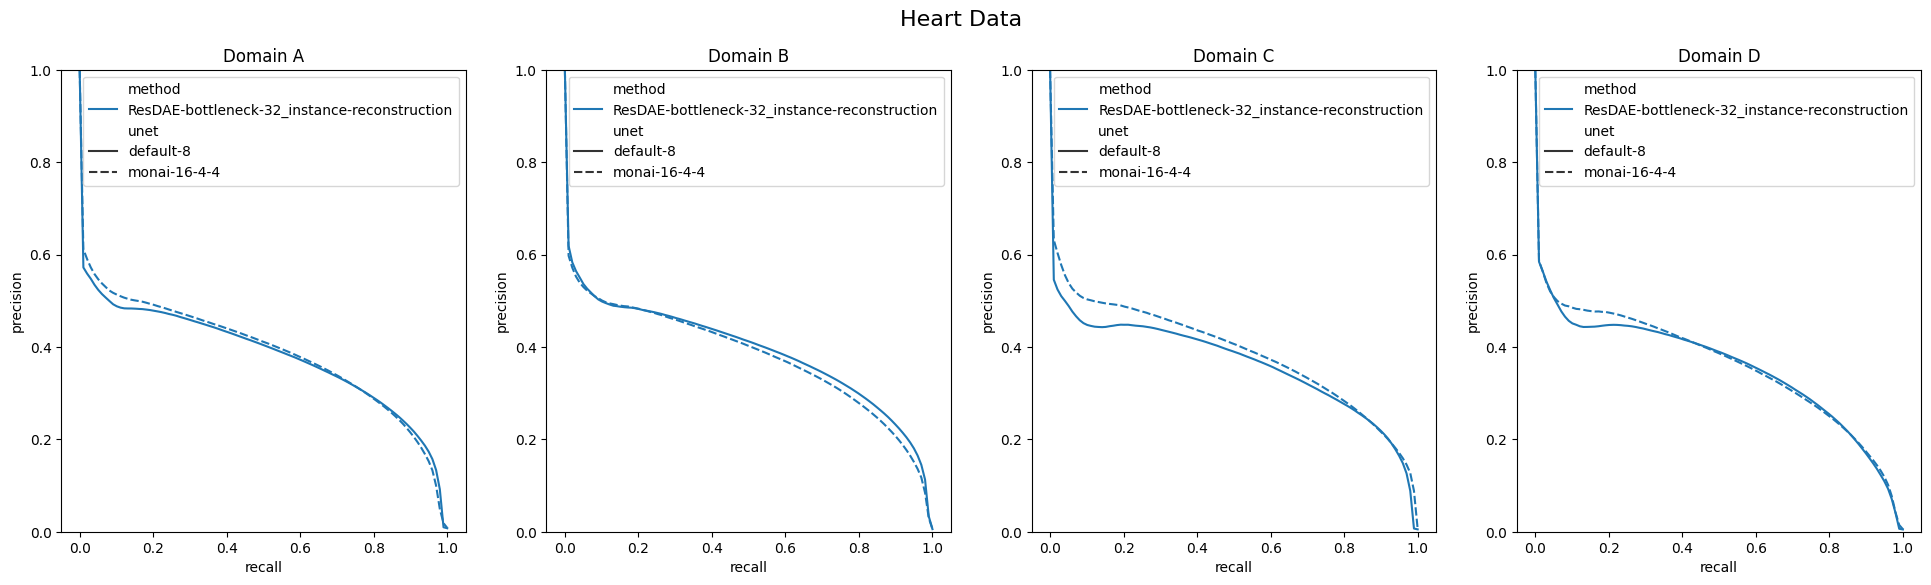

In [18]:
p = plot_pr_eval(
    data_key='heart',
    architectures=['ResDAE-bottleneck-32_instance-reconstruction'],
    unets=[
        'default-8',
        'monai-16-4-4',
    ],
    debug=False
)

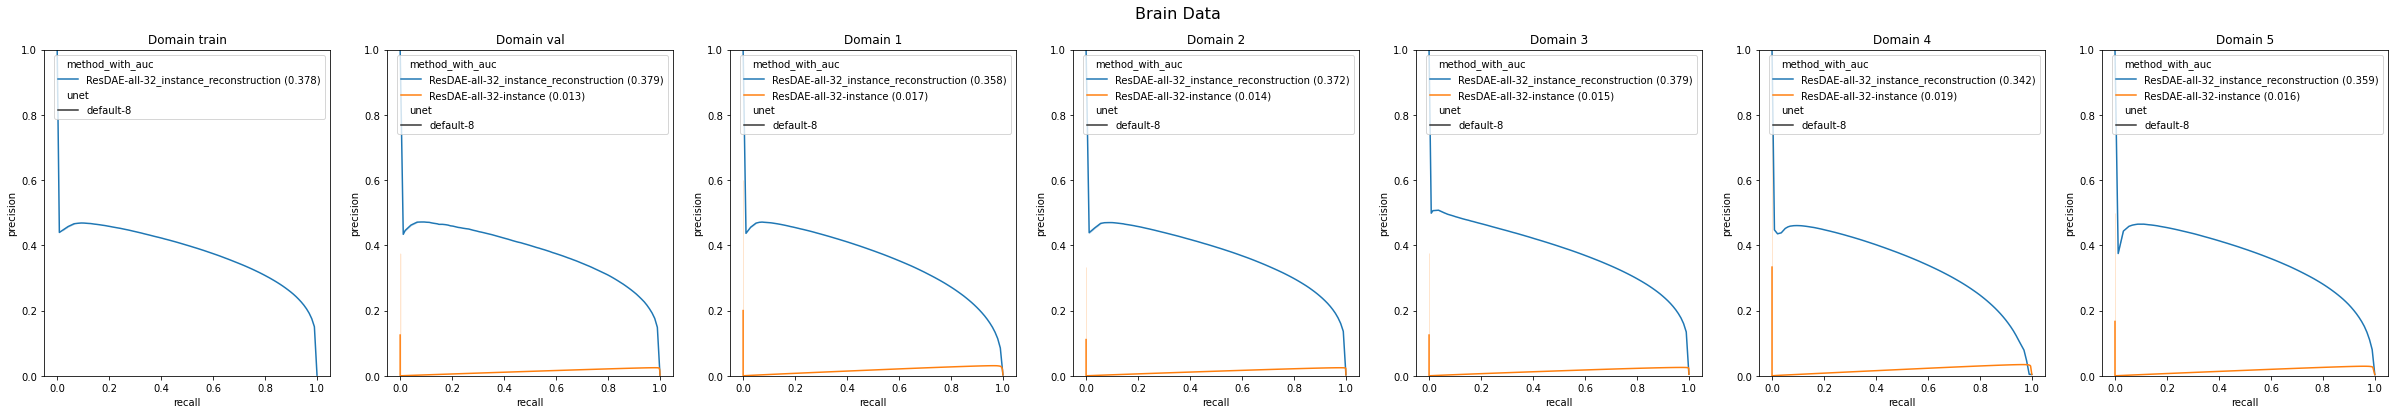

In [43]:
p = plot_pr_eval(
    data_key='brain',
    architectures= [
        'ResDAE-all-32_instance_reconstruction',
        'ResDAE-all-32-instance'
    ],
    unets = [
        'default-8',
    ],
    debug=False
)

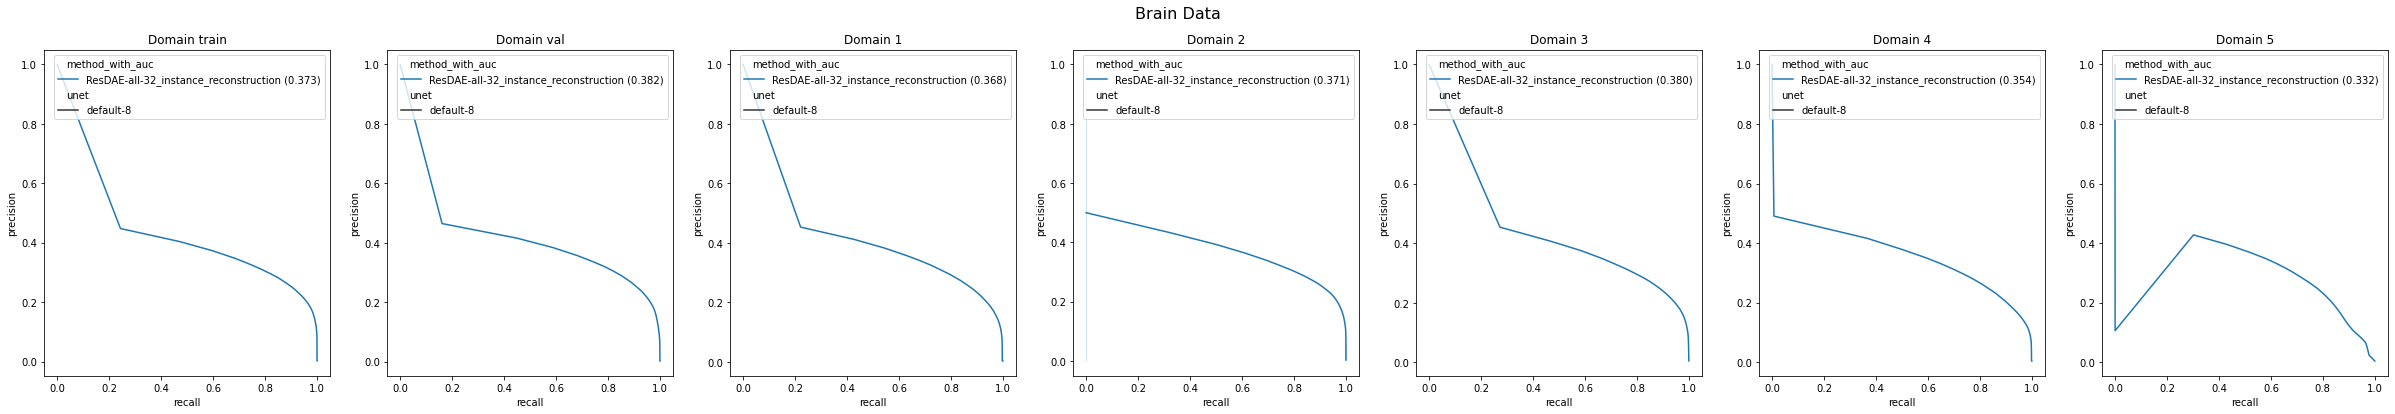

In [8]:
p = plot_pr_eval(
    data_key='brain',
    architectures= [
        'ResDAE-all-32_instance_reconstruction',
    ],
    unets = [
        'default-8',
    ],
    debug=True
)

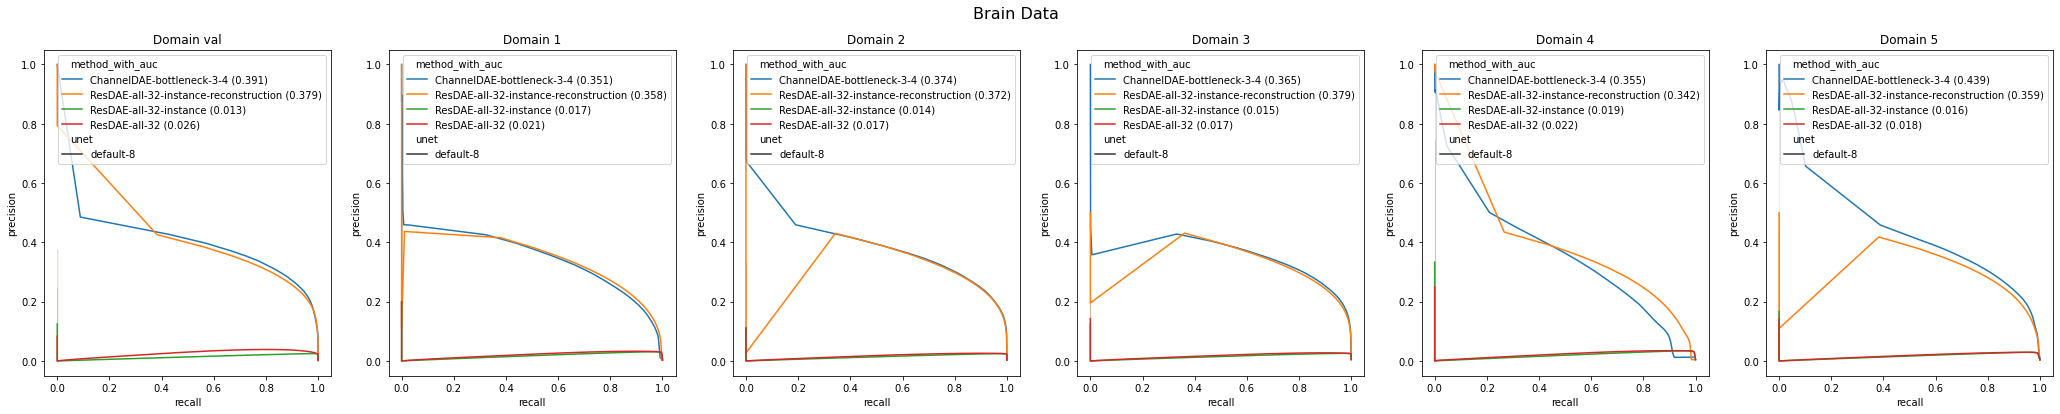

In [15]:
instance_brain_default = {
    data_key: plot_pr_eval(
        data_key=data_key,
        architectures= [
            'ChannelDAE-bottleneck-3-4',
            'ResDAE-all-32-instance-reconstruction',
            'ResDAE-all-32-instance',
            'ResDAE-all-32',
        ],
        unets = [
            'default-8',
        ],
    ) for data_key in ['brain']
}

for key in instance_brain_default:
    instance_brain_default[key].savefig(f'../../results/ae/eval/instance_brain_default-{key}_23-2-24.jpg',  bbox_inches='tight')

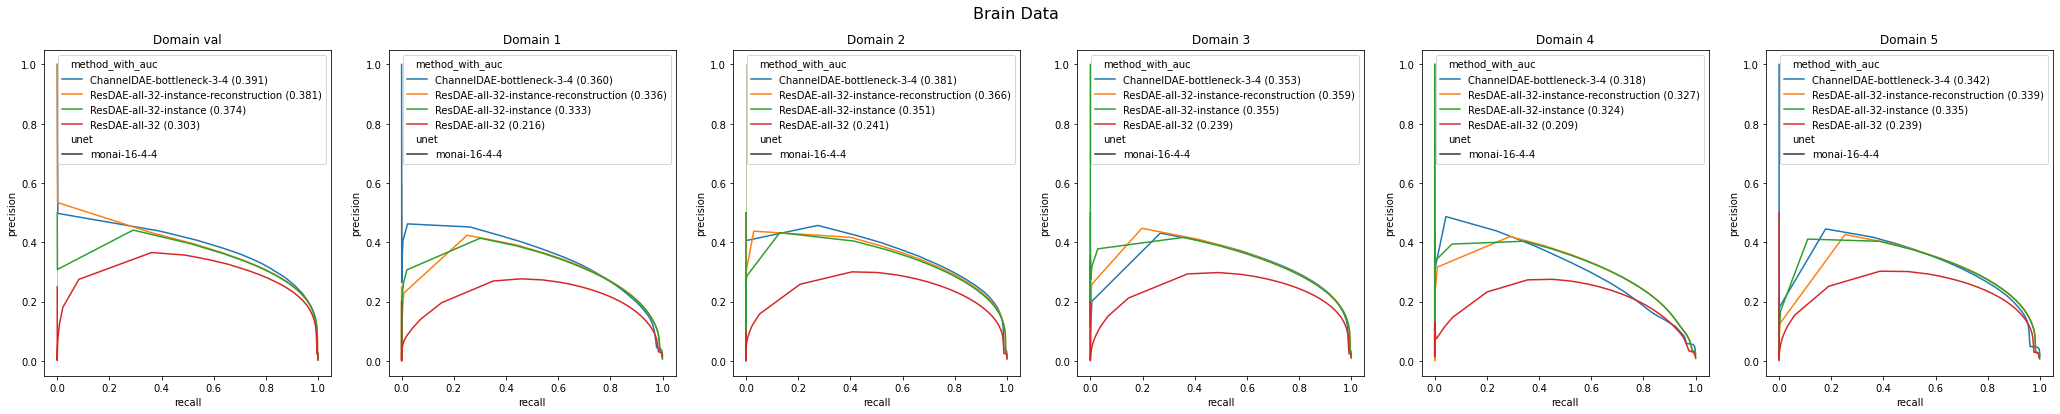

In [16]:
instance_brain_monai = {
    data_key: plot_pr_eval(
        data_key=data_key,
        architectures= [
            'ChannelDAE-bottleneck-3-4',
            'ResDAE-all-32-instance-reconstruction',
            'ResDAE-all-32-instance',
            'ResDAE-all-32',
        ],
        unets = [
            'monai-16-4-4',
        ],
    ) for data_key in ['brain']
}

for key in instance_brain_monai:
    instance_brain_monai[key].savefig(f'../../results/ae/eval/instance_brain_monai-{key}_23-2-24.jpg',  bbox_inches='tight')

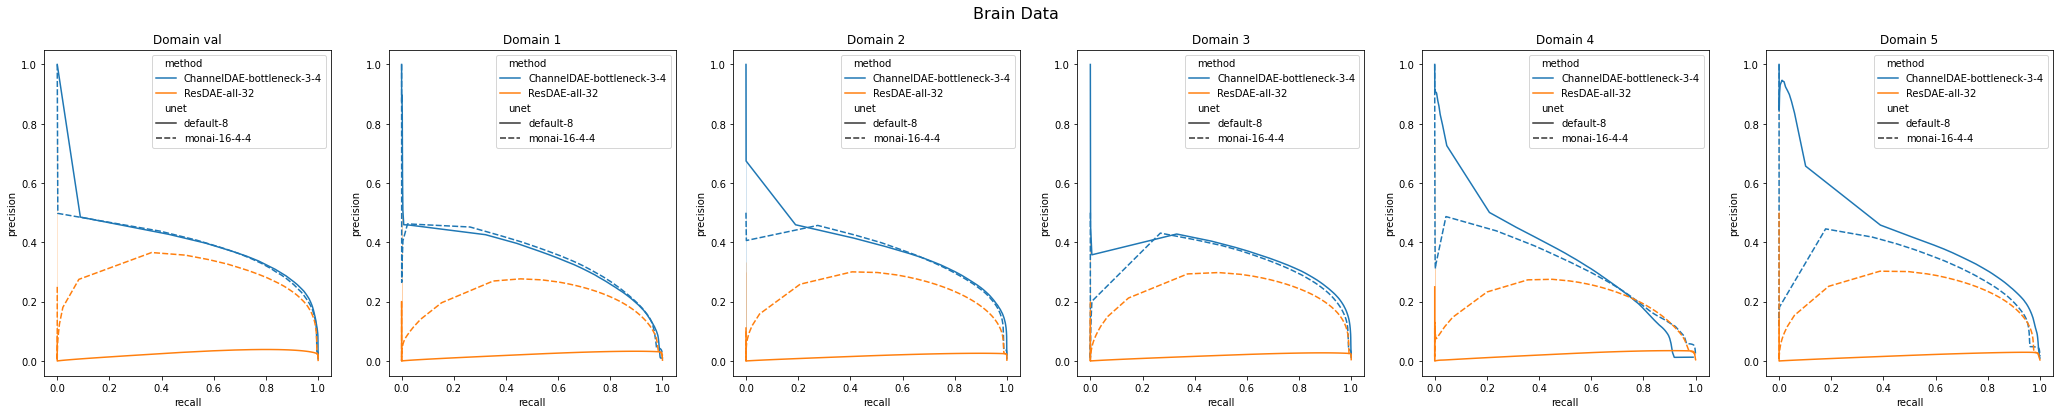

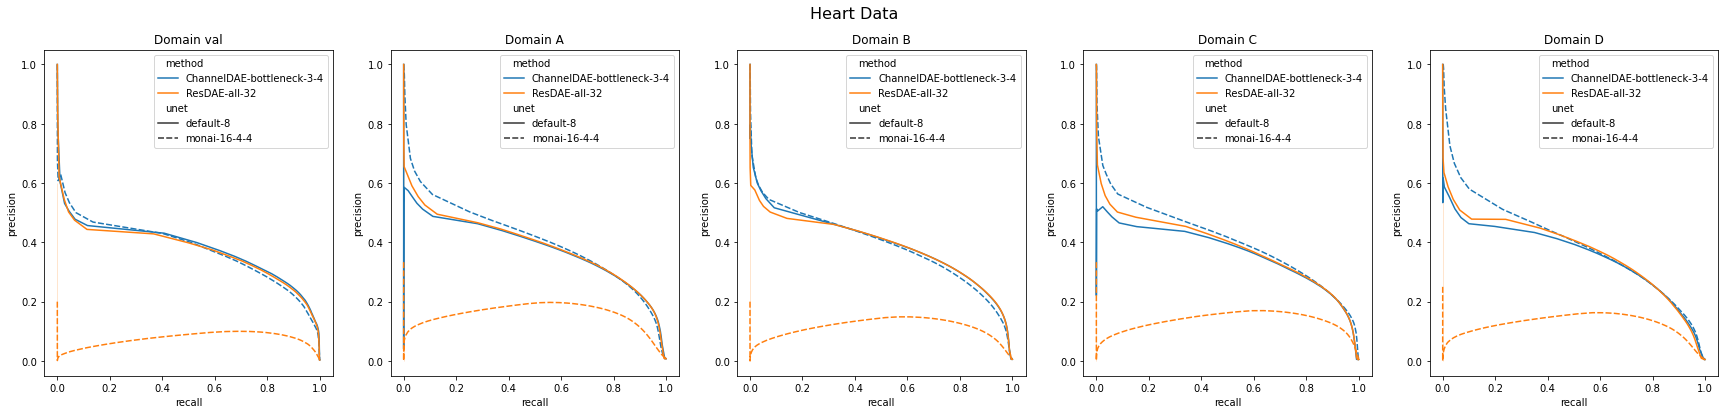

In [8]:
default_monai = {
    data_key: plot_pr_eval(
        data_key=data_key,
        architectures= [
            'ChannelDAE-bottleneck-3-4',
            'ResDAE-all-32'
        ],
        unets = [
            'default-8', 
            'monai-16-4-4',
        ],
    ) for data_key in ['brain', 'heart']
}

for key in default_monai:
    default_monai[key].savefig(f'../../results/unet/default-monai-{key}_23-2-24.png',  bbox_inches='tight')

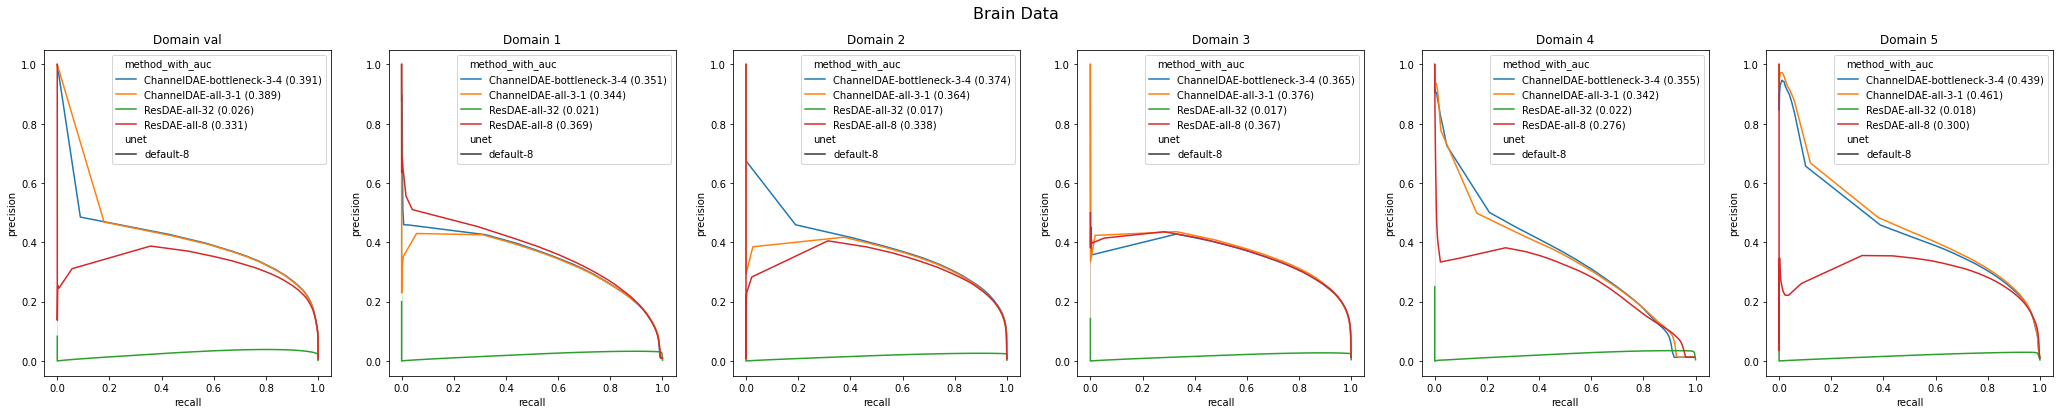

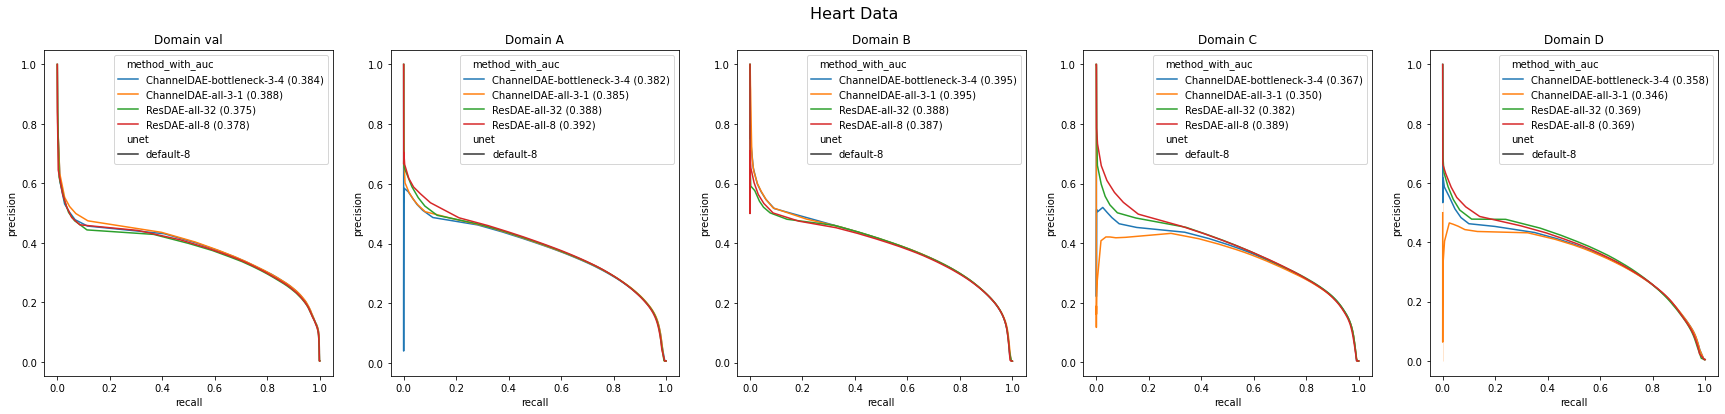

In [11]:
default8 = {
    data_key: plot_pr_eval(
        data_key=data_key,
        architectures= [
            'ChannelDAE-bottleneck-3-4',
            'ChannelDAE-all-3-1',
            'ResDAE-all-32',
            'ResDAE-all-8'
        ],
        unets = [
            'default-8', 
        ],
    ) for data_key in ['brain', 'heart']
}

for key in default8:
    default8[key].savefig(f'../../results/unet/default8-{key}_23-2-24.png',  bbox_inches='tight')

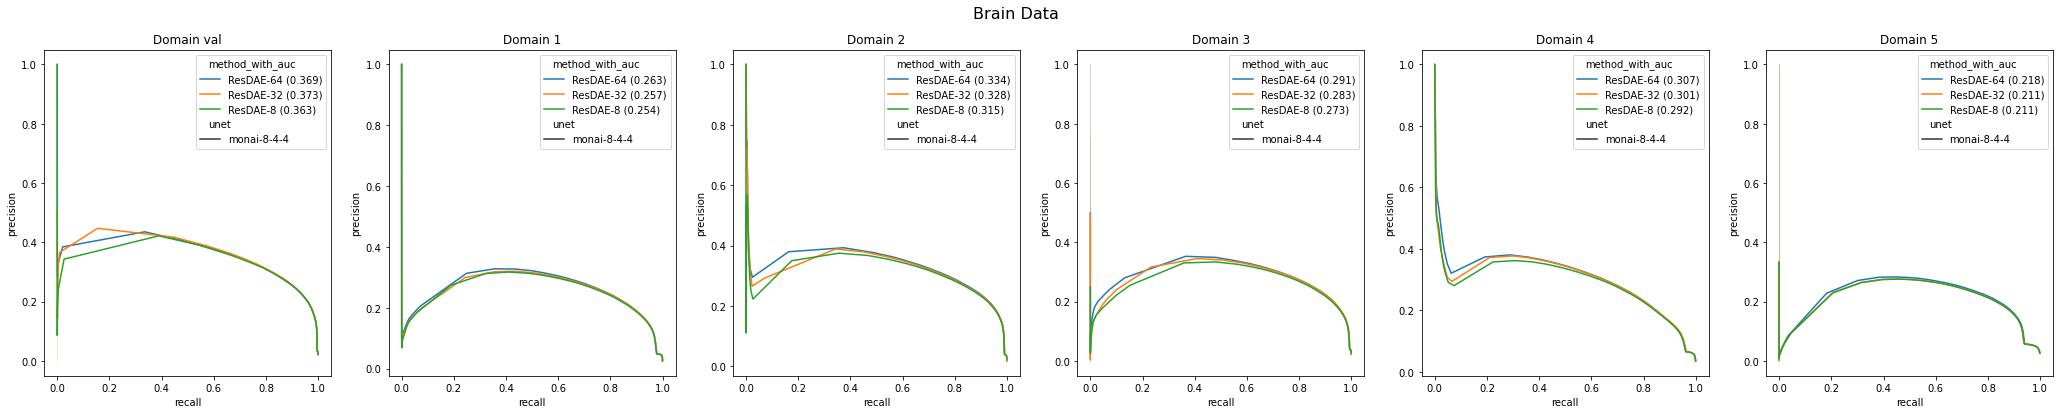

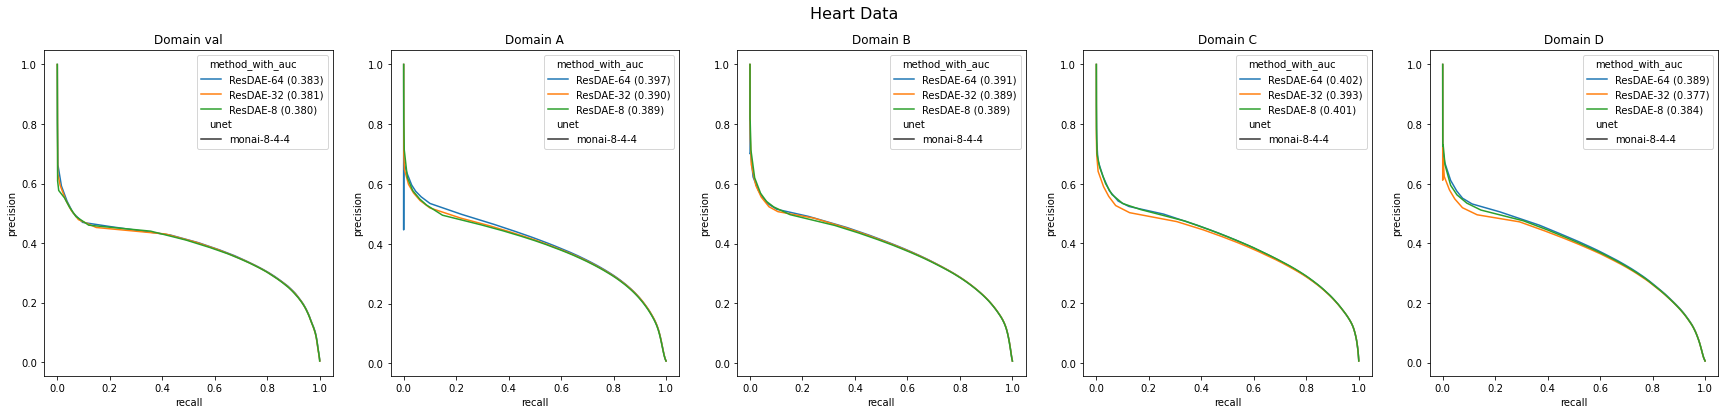

In [12]:
monai8 = {
    data_key: plot_pr_eval(
        data_key=data_key,
        architectures= [
            'ResDAE-64',
            'ResDAE-32',
            'ResDAE-8',
        ],
        unets = [
            'monai-8-4-4', 
        ],
    ) for data_key in ['brain', 'heart']
}

for key in monai8:
    monai8[key].savefig(f'../../results/unet/monai8-{key}_23-2-24.png',  bbox_inches='tight')

In [5]:
fig = monai8['brain']

In [6]:
fig
plt.show()

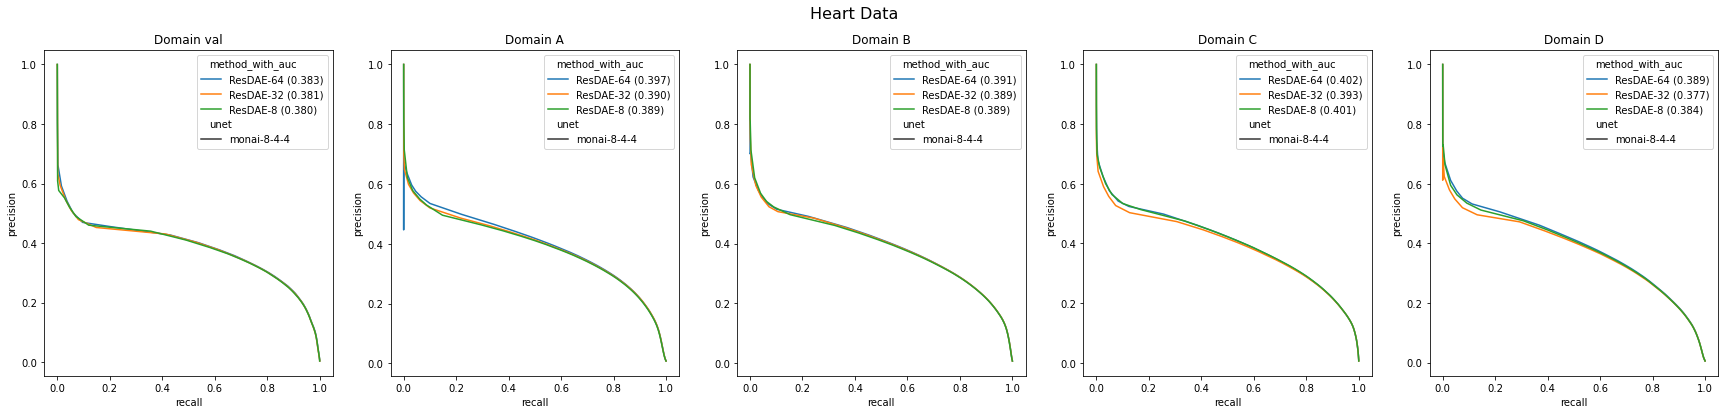

In [7]:
monai8['heart']

In [30]:
sorted_array = np.sort(np.random.rand(100) * 100)  # Example sorted array with random values
min_val, max_val = sorted_array[0], sorted_array[-1]
target_values = np.linspace(min_val, max_val, 10)

In [31]:
target_values.shape

(10,)

In [36]:
idx = np.abs(sorted_array[None, :] - target_values[:, None]).argmin(axis=1)

In [38]:
idx

array([ 0, 10, 19, 27, 39, 52, 65, 74, 85, 99])

In [1]:
import torch